In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [3]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [4]:
dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))
dk

0.01269330365086785

In [5]:
eta = np.transpose(wamos, (1, 2, 0))
eta.shape

(132, 132, 366)

In [6]:
Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0] 

Norm = dKx * dKy * dW

# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [7]:
def plot_3d_as_2d(x, y, z, radial_filter=False, extent=None, ax=None, aspect='auto', colorbar=True, cb_label='', data_min=None, data_max=None, cmap='viridis'):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    if radial_filter:
        filt = get_radial_filter(x, y)
    else:
        filt = 1
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    sh = ax.imshow((filt*z).T, origin='lower', extent=(x[0]-dx//2, x[-1]+dx//2, y[0]-dy//2, y[-1]+dy//2 ), aspect=aspect, interpolation=None, vmin=data_min, vmax=data_max, cmap=cmap)
    if colorbar:
        bar = plt.colorbar(sh, ax=ax, label=cb_label)
    if not extent is None:
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
    return ax

In [8]:
def plot_kx_ky_spec(kx, ky, spec, radial_filter=False, extent=None, ax=None, colorbar=True, spec_min=None, spec_max=None, cmap='viridis'):    
    if not spec_min is None:
        data = np.where(spec<spec_min, spec_min, spec)
    if not spec_max is None:
        data = np.where(spec>spec_max, spec_max, spec)
    ax = plot_3d_as_2d(kx, ky, spec, radial_filter, extent, ax, aspect=1, colorbar=colorbar, data_min=spec_min, data_max=spec_max, cmap=cmap)
    ax.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
    ax.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
    return ax

In [9]:
def plot_w_slice(at_w, extent, ax=None, dB=None, vmin=None, save=False):
        '''
        plots the integrated kx-ky-spectrum and the integrated k-omega-spectrum
        '''
        if at_w > 0:
            i = np.argmin(np.abs(w[Nt//2:]-at_w))
            print(at_w, w[Nt//2+i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)
        else:
            i = np.argmin(np.abs(w[:Nt//2]-at_w))
            print(at_w, w[i], i) 
            plotting_interface.plot_kx_ky_spec(Kx, Ky, power_Spectrum[:,:,Nt//2+i], extent=extent, ax=ax)

In [10]:
at_w = 0.8
i = np.argmin(np.abs(w[Nt//2:]-at_w))

In [11]:
# Flatten the array and get the indices of the sorted values
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]

# Take the top 20 indices
top_20_indices = flat_indices[:50]

# Convert flat indices to 2D indices
top_20_indices_2d = np.unravel_index(top_20_indices, power_Spectrum[:,:,Nt//2+i].shape)

kx_ind, ky_ind = top_20_indices_2d[0], top_20_indices_2d[1]

0.8 0.8006578727045026 115


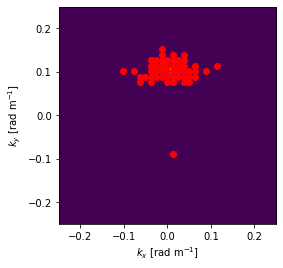

In [12]:
plot_w_slice(at_w, extent = [-0.25,0.25, -0.25, 0.25], ax=None, dB=None, vmin=None, save=False)

plt.scatter(Kx[kx_ind], Ky[ky_ind], color = 'red')

# 1) Triplet Calculation

In [13]:
def felip(x, a, b):
    return np.sqrt(np.abs(b**2 * (1-x**2/b**2)))

In [14]:
def fit_elipse(at_w):
    '''Slices the Spectrum at_w and then fits an ellise to the points

    Input : at_w  location of the omgea slice (positive)
    
    Output : x_values  ellipse fitting x vals
             y_values  ellipse fitting y vals'''
    
    ## Find the rough Triplet value points 
    i = np.argmin(np.abs(w[Nt//2:]-at_w))
    flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
    top_indices = flat_indices[:50] # Take the top 20 indices
    top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
    kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
    triplet_x = Kx[kx_ind]
    triplet_y = Ky[ky_ind]
    
    ### Perform Elipse fitting ###
    
    # Curve fit when there's less than 5 negative ky values (ie not a circle)
    cond = (triplet_y < 0)
    if len(triplet_y[cond]) < 5:
        
        # perform fitting
        pars0 = (0.2, 0.2)
        ind = (triplet_y > 0)
        popt, pcov = curve_fit(felip, triplet_x[ind], triplet_y[ind], absolute_sigma=True, p0=pars0)

        # extract best-fit parameter and its error
        a_opt = popt[0]
        b_opt = popt[1]

        # creating x interval to include in y fit
        x = np.linspace(-0.2, 0.2, 50)
        y_fit = felip(x, *popt)
        
        # Find the indices two minimum values of y_fit
        min_indices = np.argsort(y_fit)[:2]

        ellipse_x = x[np.min(min_indices):np.max(min_indices)+1]
        ellipse_y = y_fit[np.min(min_indices):np.max(min_indices)+1]
        
        return ellipse_x, ellipse_y
    
    else:
        
        x = triplet_x
        y = triplet_y

        A = np.stack([x**2, x * y, y**2, x, y]).T
        b = np.ones_like(x)
        L = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

        xlin = np.linspace(-0.3, 0.3, 50)
        ylin = np.linspace(-0.3, 0.3, 50)
        X, Y = np.meshgrid(xlin, ylin)

        Z = L[0]*X**2 + L[1]*X*Y + L[2]*Y**2 + L[3]*X + L[4]*Y
        
        # Coordinates on the fitted curve
        contour_levels = [1]
        contour_lines = plt.contour(X, Y, Z, contour_levels, colors='red')
        contour_points = contour_lines.collections[0].get_paths()[0]
        coordinates_on_curve = contour_points.vertices
        
        plt.close()

        # Fitted curve full ellipse
        ellipse_x_full = coordinates_on_curve[:, 0]
        ellipse_y_full = coordinates_on_curve[:, 1]
        
        cond1 = (ellipse_y_full > 0)
        ellipse_x = ellipse_x_full[cond1]
        ellipse_y = ellipse_y_full[cond1]

        
        return ellipse_x, ellipse_y

In [14]:
def fit_elipse(at_w):
    '''Slices the Spectrum at_w and then fits an ellise to the points

    Input : at_w  location of the omgea slice (positive)
    
    Output : x_values  ellipse fitting x vals
             y_values  ellipse fitting y vals'''
    
    ## Find the rough Triplet value points 
    i = np.argmin(np.abs(w[Nt//2:]-at_w))
    flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
    top_indices = flat_indices[:50] # Take the top 20 indices
    top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
    kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
    triplet_x = Kx[kx_ind]
    triplet_y = Ky[ky_ind]
    
    ### Perform Elipse fitting ###
    
    # Curve fit when there's less than 5 negative ky values (ie not a circle)
    cond = (triplet_y < 0)
    if len(triplet_y[cond]) < 5:
        
        # perform fitting
        pars0 = (0.2, 0.2)
        ind = (triplet_y > 0)
        popt, pcov = curve_fit(felip, triplet_x[ind], triplet_y[ind], absolute_sigma=True, p0=pars0)

        # extract best-fit parameter and its error
        a_opt = popt[0]
        b_opt = popt[1]

        # creating x interval to include in y fit
        x = np.linspace(-0.2, 0.2, 50)
        y_fit = felip(x, *popt)
        
        # Find the indices two minimum values of y_fit
        min_indices = np.argsort(y_fit)[:2]

        ellipse_x_full = x[np.min(min_indices):np.max(min_indices)+1]
        ellipse_y_full = y_fit[np.min(min_indices):np.max(min_indices)+1]
        
        cond2 = (np.min(triplet_x[ind]) < ellipse_x_full) & (ellipse_x_full < np.max(triplet_x[ind]))
        ellipse_x = ellipse_x_full[cond2]
        ellipse_y = ellipse_y_full[cond2]

        
        return ellipse_x, ellipse_y
    
    else:
        
        x = triplet_x
        y = triplet_y

        A = np.stack([x**2, x * y, y**2, x, y]).T
        b = np.ones_like(x)
        L = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()

        #xlin = np.linspace(np.min(x), np.max(x), 50)
        #ylin = np.linspace(np.min(y), np.max(y), 50)
        xlin = np.linspace(-0.3, 0.3, 50)
        ylin = np.linspace(-0.3, 0.3, 50)
        X, Y = np.meshgrid(xlin, ylin)

        Z = L[0]*X**2 + L[1]*X*Y + L[2]*Y**2 + L[3]*X + L[4]*Y
        
        # Coordinates on the fitted curve
        contour_levels = [1]
        contour_lines = plt.contour(X, Y, Z, contour_levels, colors='red')
        contour_points = contour_lines.collections[0].get_paths()[0]
        coordinates_on_curve = contour_points.vertices
        
        plt.close()

        # Fitted curve full ellipse
        ellipse_x_full = coordinates_on_curve[:, 0]
        ellipse_y_full = coordinates_on_curve[:, 1]
        
        cond0 = (y>0)
        plus_trip_x = x[cond0]
        plus_trip_y = y[cond0]
        
        cond1 = (ellipse_y_full > 0)
        ellipse_x_nonzero = ellipse_x_full[cond1]
        ellipse_y_nonzero = ellipse_y_full[cond1]
        
        cond2 = (np.min(plus_trip_x) < ellipse_x_nonzero) & (ellipse_x_nonzero < np.max(plus_trip_x))
        ellipse_x = ellipse_x_nonzero[cond2]
        ellipse_y = ellipse_y_nonzero[cond2]

        
        return ellipse_x, ellipse_y

In [15]:
# Define w values
w_values = np.arange(0.3, 1.25, 0.01)

# Initialize arrays to store results
all_ellipse_x = []
all_ellipse_y = []

# Iterate over w values
for w_value in w_values:
    ellipse_x, ellipse_y = fit_elipse(w_value)
    all_ellipse_x.append(ellipse_x)
    all_ellipse_y.append(ellipse_y)

C:\Users\josep\Documents\Anaconda\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [44]:
%matplotlib widget

(0.0, 1.2)

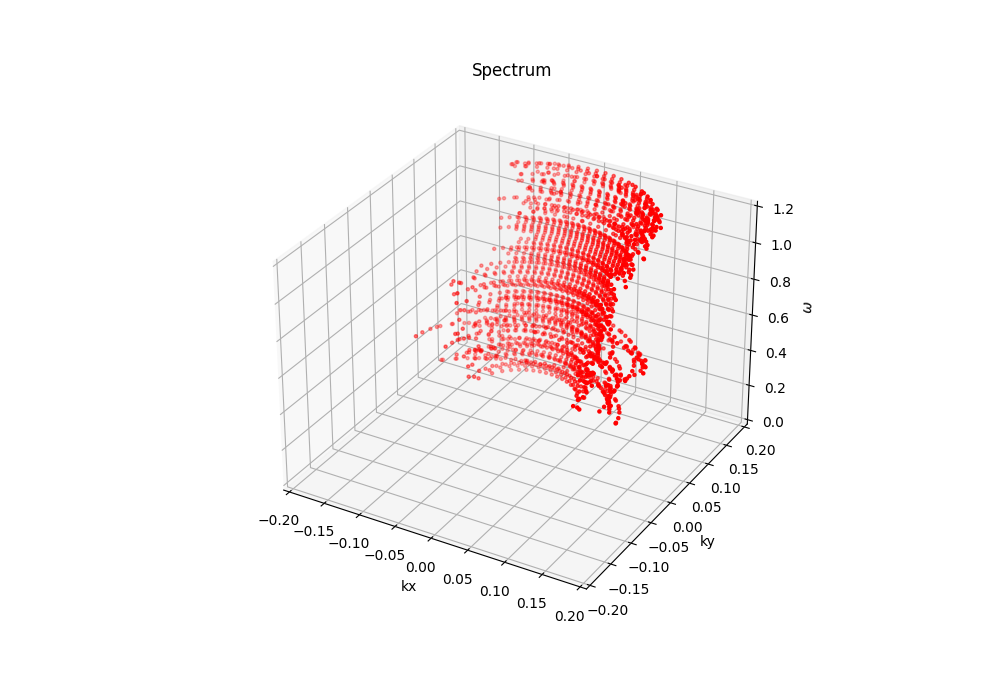

In [45]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in range(len(w_values)):
    ax.scatter3D(all_ellipse_x[i], all_ellipse_y[i], w_values[i], color = "red", s = 5)
    
plt.title("Spectrum")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])

# 2) PCS Method

In [18]:
from scipy.stats import t

In [19]:
%matplotlib inline

## 2.1) One Slice

In [20]:
k_slice = 0.12

In [21]:
kx_triplets = np.concatenate(all_ellipse_x)
ky_triplets = np.concatenate(all_ellipse_y)
w_triplets = np.repeat(w_values, [len(arr) for arr in all_ellipse_x])

In [22]:
k_abs = np.sqrt(kx_triplets**2 + ky_triplets**2)

In [23]:
reso = 0.001
ind = np.where(((k_slice - reso) < k_abs ) & ( k_abs < (k_slice + reso)))

In [24]:
theta = np.arctan2(ky_triplets, kx_triplets)

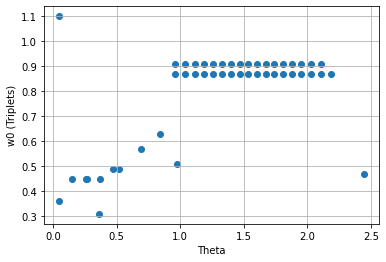

In [25]:
plt.scatter(theta[ind], w_triplets[ind])

plt.xlabel("Theta")
plt.ylabel("w0 (Triplets)")
plt.grid(True)

In [26]:
def sinusoidinal(x, a, b):
    return a*np.cos(x - b) 

In [27]:
w_triplets[ind]

array([0.31, 0.36, 0.45, 0.45, 0.45, 0.45, 0.47, 0.49, 0.49, 0.51, 0.57,
       0.63, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87,
       0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.91, 0.91, 0.91,
       0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91,
       0.91, 0.91, 0.91, 1.1 ])

In [28]:
x1 = theta[ind]
y = ( w_triplets[ind] - np.sqrt(9.81*k_slice) )  / k_slice

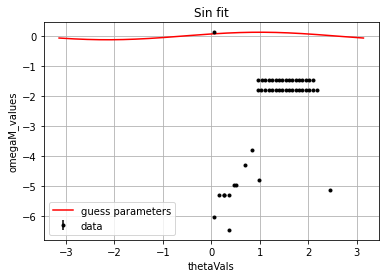

In [29]:
# plot the raw data
plt.errorbar(x1, y, yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')


# initial guess
pars0 = ( max(y), 1)

# overlay exponential 

x = np.linspace(-np.pi, np.pi, 1000)

plt.plot(x, sinusoidinal(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Sin fit");

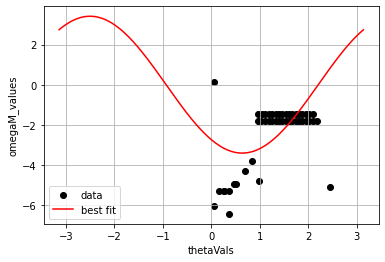

In [30]:
popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# extract best-fit parameter and its error
b_opt = popt[1]
ab_opt_err = np.sqrt(pcov[1, 1])


# plot data
plt.scatter(x1, y, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-np.pi, np.pi, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
#plt.ylim(1.65, 2.08)
plt.legend();

In [31]:
a_opt

-3.419375425944603

In [32]:
def grubbs_test(x, y):
    """
    Grubb's test removes outlier in y axis and also removes the corresponding x value
    """

    # Gets mean and standard deviation of data
    mean_data = np.mean(y)
    std_data = np.std(y)

    # Calculate Grubbs test statistic
    z_scores = np.abs((y - mean_data) / std_data)
    max_z = np.max(z_scores)

    # Calculate critical value based on the t-distribution
    n = len(y)
    critical_value = t.ppf(0.975, n - 2) / np.sqrt(n)

    # Identify and removes any outlier
    outlier_index = np.argmax(z_scores)
    if max_z > critical_value:
        #print(f"Outlier detected at index {outlier_index}, value: {y[outlier_index]}")
        y = np.delete(y, outlier_index)
        x = np.delete(x, outlier_index)

        
    return x, y 

In [33]:
x1, y = grubbs_test(x1, y)

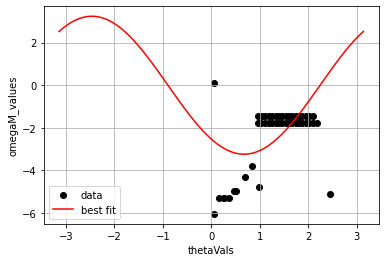

In [34]:
popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
a_opt_err = np.sqrt(pcov[0, 0])

# extract best-fit parameter and its error
b_opt = popt[1]
ab_opt_err = np.sqrt(pcov[1, 1])


# plot data
plt.scatter(x1, y, color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-np.pi, np.pi, 1000)
y_fit = sinusoidinal(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")

plt.grid(True)
plt.xlabel('thetaVals')
plt.ylabel('omegaM_values')
#plt.ylim(1.65, 2.08)
plt.legend();

In [35]:
a_opt

-3.238568236094825

## 2.2) Loop for many slices

In [36]:
kx_triplets = np.concatenate(all_ellipse_x)
ky_triplets = np.concatenate(all_ellipse_y)
w_triplets = np.repeat(w_values, [len(arr) for arr in all_ellipse_x])

In [37]:
#cut_k_array = np.arange(0.001, 0.35, 0.01)
cut_k_array = np.arange(0.05, 0.3, 0.01)

U_array = []
Φ_array = []

for i in range(len(cut_k_array)):
    k_slice = cut_k_array[i]
    
    k_abs = np.sqrt(kx_triplets**2 + ky_triplets**2)
    theta = np.arctan2(ky_triplets, kx_triplets)
    
    reso = 0.01
    ind = np.where(((k_slice - reso) < k_abs ) & ( k_abs < (k_slice + reso)))
    
    if len(w_triplets[ind]) > 1:
    
        x1 = theta[ind]
        y = ( w_triplets[ind] - np.sqrt(9.81*k_slice) )  / k_slice
    
        # Perform Grubbs test
        x1, y = grubbs_test(x1, y)
    
    
        # initial guess
        pars0 = ( max(y), 1)
        popt, pcov = curve_fit(sinusoidinal, x1, y, absolute_sigma=True, p0=pars0)

        # U value
        U_opt = popt[0]
        U_opt_err = np.sqrt(pcov[0, 0])
        U_array.append(np.abs(U_opt))
        
        # Φ
        Φ_opt = popt[1]
        Φ_opt_err = np.sqrt(pcov[1, 1])
        
        if U_opt > 0:
            Φ_opt = np.pi - Φ_opt
            # Condition due to definition of direction of current 
        
        Φ_array.append(Φ_opt)
    
    else:
        U_array.append(None)
        Φ_array.append(None)
            
        

<ipython-input-32-f85b713f9694>:11: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((y - mean_data) / std_data)


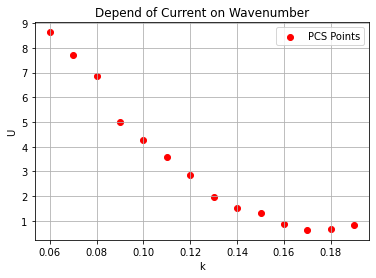

In [40]:
plt.scatter(cut_k_array, U_array, color = 'red', label = 'PCS Points')

plt.xlabel("k")
plt.ylabel("U")
plt.title("Depend of Current on Wavenumber")
plt.grid(True)
plt.legend()
#plt.ylim(0, 1.1)

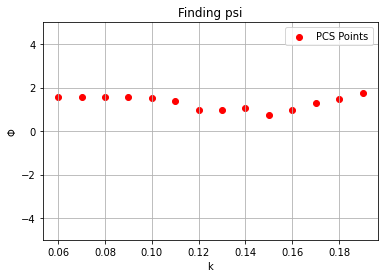

In [41]:
plt.scatter(cut_k_array, Φ_array, color = 'red', label = 'PCS Points')

plt.xlabel("k")
plt.ylabel("Φ")

plt.title("Finding psi")
plt.ylim(-5,5)
plt.grid(True)
plt.legend()

In [18]:
def felip(x, a, b):
    return np.sqrt(np.abs(b**2 * (1-(x**2)/(b**2))))

In [19]:
at_w = 1.2

In [20]:
## Find the rough Triplet value points 
i = np.argmin(np.abs(w[Nt//2:]-at_w))
flat_indices = np.argsort(power_Spectrum[:,:,Nt//2+i].flatten())[::-1]
top_indices = flat_indices[:50] # Take the top 50 indices
top_indices_2d = np.unravel_index(top_indices, power_Spectrum[:,:,Nt//2+i].shape)
kx_ind, ky_ind = top_indices_2d[0], top_indices_2d[1]
    
triplet_x = Kx[kx_ind]
triplet_y = Ky[ky_ind]

In [21]:
# Perform Elipse fitting
cond = (triplet_y < 0)

if len(triplet_y[cond]) < 5:
    print("perform yoke")

In [22]:
# perform fitting
pars0 = (0.2, 0.2)

ind = (triplet_y > 0)

popt, pcov = curve_fit(felip, triplet_x[ind], triplet_y[ind], absolute_sigma=True, p0=pars0)

# extract best-fit parameter and its error
a_opt = popt[0]
b_opt = popt[1]

# plot data
plt.errorbar(triplet_x[ind], triplet_y[ind], yerr=0, fmt=".", color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(-0.2, 0.2, 100)
y_fit = felip(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")

#plt.plot(x[min_indices[0]:min_indices[1]+1], y_fit[min_indices[0]:min_indices[1]+1], color="blue", label="best fit")


plt.plot(x8, y8, color="blue", label="best fit")


plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.legend();

TypeError: errorbar() missing 1 required positional argument: 'z'

In [ ]:
# Find the indices corresponding to the two minimum values of y_fit
min_indices = np.argsort(y_fit)[:2]

# Extract the corresponding x and y_fit values
#x_min_neg = x[]

In [ ]:
min_indices

In [ ]:
plt.plot(x[np.min(min_indices):np.max(min_indices)+1], y_fit[np.min(min_indices):np.max(min_indices)+1], color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")


plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

In [ ]:
plot_w_slice(at_w, extent = [-0.25,0.25, -0.25, 0.25], ax=None, dB=None, vmin=None, save=False)

plt.plot(x, y_fit, color="red", label="best fit")

In [ ]:
x8, y8 = fit_elipse(at_w)

In [ ]:
fit_elipse(at_w)

In [ ]:
y8